# Recitation 10: Causality
Due by Friday April 30 at 11:59pm

In this recitation you will get some experience understanding the impact of price on requests for Uber trips in New York City, how causality plays a role in estimating this impact, and how one can use an A/B experiment to better understand this impact.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Part 1: Exploratory Data Analysis

Begin by reading in `uber_rec10.csv` and printing out the first 5 rows.

This is a file with realistic (but not real) data based on the NYC taxi dataset. 

For each zone (location_id) in NYC and each hour of day, for 4 saturdays in July 2017, it contains:
* sessions: the number of sessions from riders
* drivers: the number of drivers
* desire_to_ride: a number indicating riders' price elasticity, i.e., how much an increase in price would discourage them from taking a trip. This would not typically be observed in reality but is provided to allow simulation. Typically, when we have a larger desire to ride, this is because of some event (it's raining, a big concert just got out) and we also see more sessions than usual.


Then number of sessions is the number of people who are looking at the rider app, interested in taking a trip if the price is right. Some sessions "convert", i.e., request a car, while others do not. The price is the biggest factor in determining whether a session converts --- lower prices cause more conversion. The focus of this recitation will be understanding the causal impact of price on session conversion. 

You can see the map for zones in Manhattan here, https://www1.nyc.gov/assets/tlc/images/content/pages/about/taxi_zone_map_manhattan.jpg and the maps for the other borroughs here: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page (scroll down to "Taxi Zone Maps and Lookup Tables")

In [8]:
# YOUR CODE HERE
df_part1 = pd.read_csv('uber_rec10.csv')
df_part1.head()

,location_id,pickup_hour,pickup_date,sessions,drivers,desire_to_ride
0,144,20,2017-07-14,436.0,137.0,0.862876
1,226,8,2017-07-07,168.0,47.0,0.958855
2,170,19,2017-07-28,706.0,163.0,1.052971
3,249,7,2017-07-28,284.0,59.0,1.163299
4,255,9,2017-07-07,371.0,66.0,1.605906


To get a sense for the data, for location_id 249 (the west village in Manhattan --- selected arbitrarily), plot the number of sessions versus the hour of the day, 
for each of the 4 saturdays in the data, all on one plot.  Since the data isn't sorted by hour, it is easiest to plot using dots.

In [24]:
# YOUR CODE HERE
sat1 = df_part1[df_part1['pickup_date'] == '2017-07-07']
sat2 = df_part1[df_part1['pickup_date'] == '2017-07-14']
sat3 = df_part1[df_part1['pickup_date'] == '2017-07-21']
sat4 = df_part1[df_part1['pickup_date'] == '2017-07-28']

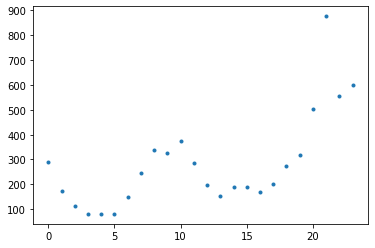

In [28]:
data1 = sat1[sat1['location_id'] == 249]
plt.plot(data1['pickup_hour'], data1['sessions'], '.')

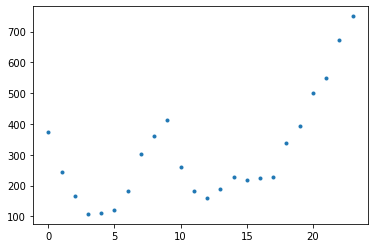

In [29]:
data2 = sat2[sat2['location_id'] == 249]
plt.plot(data2['pickup_hour'], data2['sessions'], '.')

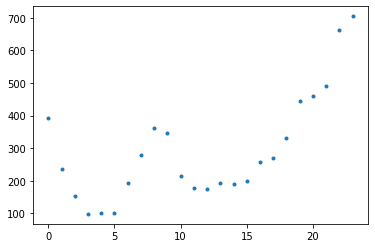

In [30]:
data3 = sat3[sat3['location_id'] == 249]
plt.plot(data3['pickup_hour'], data3['sessions'], '.')

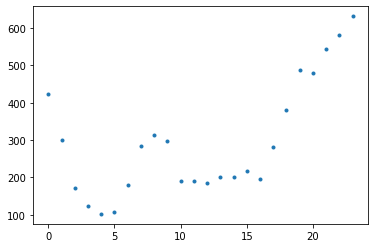

In [31]:
data4 = sat4[sat4['location_id'] == 249]
plt.plot(data4['pickup_hour'], data4['sessions'], '.')

Make another plot where each combination of pickup_hour / pickup_date / location_id is a separate dot.
Put the number of drivers on the x-axis and the number of sessions on the y-axis.

Notice how they are correlated with each other. Uber drivers know where demand will be high and are also guided by 
a heatmap in the driver app showing surge pricing. This allows supply and demand to be roughly matched, so that there
are usually enough drivers to serve demand, but not too many extra drivers (having extra drivers is undesirable, because it
means that people are spending time but no one is benefiting from the time being spent).

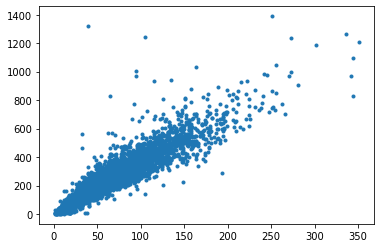

In [36]:
# YOUR CODE HERE
plt.plot(df_part1['drivers'], df_part1['sessions'], '.')

Unfortunately, the number of drivers is not always perfectly matched to the number of sessions. In other words, supply is not always balanced with demand.

This is essentially because life holds surprises --- sometimes things are busier than usual for unexpected reasons.

When this happens, Uber raises the price. In 2017, this was done using the surge pricing system. This charges riders a multiple of the ordinary fare based on, roughly speaking, how many more sessions there are than can be served by the available drivers. If the surge multiple is 2, then riders pay twice the normal fare. If the surge multiple is 1, riders pay the normal fare.

This serves two important purposes. First, it compensates drivers more for being smart and hard-working enough to be available when demand was going to be high. That encourages them to continue to be smart and hard-working in the future. Second, since there aren't enough drivers for everyone to take a trip, some people with a session on the rider app aren't going to be able to ride. Raising the price separates the people who have other options (e.g., taking the subway, walking, waiting 10 minutes for more cars to arrive and prices to drop) from those that don't and gives the limited supply of cars to those that 
are most willing to pay for them.

The desire to ride is correlated with how balanced supply and demand are. To see this, make a plot of desire to ride (on the x-axis) and the ratio of sessions over drivers (on the y-axis).
You should see that when the desire to ride is high, the number of sessions relative to the number of drivers is also high. This is because the same events that cause people to look at the uber app more than usual (rain, a big concert or sporting event that just finished, a public transit outage) also cause them to want to ride on Uber more than usual, and makes many of them willing to pay more money.

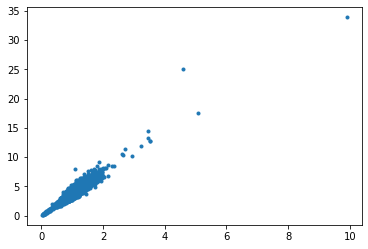

In [38]:
# YOUR CODE HERE
plt.plot(df_part1['desire_to_ride'], df_part1['sessions']/df_part1['drivers'], '.')

### Part 2: Simulating the effect of prices on conversion

We are going to simulate prices set by the surge system and the effect that has on session conversion.  We begin by defining a function, `conversion_rate`, that accepts a surge multiplier set in the hour and location_id, as well as the desire_to_ride value for that hour and location_id from the data we read in. In our simulation, this will give the conversion rate for our riders.

In [40]:
def conversion_rate(surge, desire_to_ride):
    return min(1,max(0,0.8 - (surge-1)/desire_to_ride))

Make a plot of the conversion rate versus surge multiplier, over the range of surge multipliers from 1 to 2, for three different values of the desire_to_ride: 0.5, 1, and 2.

You should see that when the desire_to_ride is high, price has a smaller impact on conversion.

In [69]:
# YOUR CODE HERE
surge_multipliers = [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]
desire_to_ride = [0.5, 1, 2]
plot_data = pd.DataFrame()
surges = []
conversion_rates0 = []
conversion_rates1 = []
conversion_rates2 = []

for i in surge_multipliers:
    surges.append(i)
    for j in desire_to_ride:
        if j == 0.5:
            conversion_rates0.append(conversion_rate(i,j))
        elif j == 1:
            conversion_rates1.append(conversion_rate(i,j))
        elif j == 2:
            conversion_rates2.append(conversion_rate(i,j))
        
plot_data['surge'] = surges
plot_data['conversion_rates_0'] = conversion_rates0
plot_data['conversion_rates_1'] = conversion_rates1
plot_data['conversion_rates_2'] = conversion_rates2
plot_data.head()

,surge,conversion_rates_0,conversion_rates_1,conversion_rates_2
0,1.0,8.000000e-01,0.8,0.80
1,1.1,6.000000e-01,0.7,0.75
2,1.2,4.000000e-01,0.6,0.70
3,1.3,2.000000e-01,0.5,0.65
4,1.4,2.220446e-16,0.4,0.60


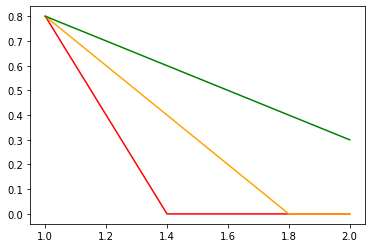

In [70]:
plt.plot(plot_data['surge'],plot_data['conversion_rates_0'],color='red')
plt.plot(plot_data['surge'],plot_data['conversion_rates_1'],color='orange')
plt.plot(plot_data['surge'],plot_data['conversion_rates_2'],color='green')

**Analysis: If desire to ride is higher (green, then orange, then red data), then as the surge multiplier increases along the x-axis, the conversion rate decreases. For the green data (highest desire to ride), the conversion rate decreases the smallest as the surge multipier increases when compared with the orange and red data (lower desires to ride). This is expected as indicated in the problem.**

Now define a surge pricing function. This searches for the smallest surge multiple (greater than or equal to 1) such that the available drivers in the location_id can serve all of the sessions that convert in that hour, according to a prediction for conversion rate. Because the desire_to_ride is unknown to the surge pricing system, use the average desire_to_ride in the dataset. For the purposes of this recitation, assume that a driver can do 3 trips in an hour.

Your function should start at a surge of 1 and then increase the surge multiple in increments of 0.1. It should stop when it finds the first price such that the number of sessions that would convert (at the average desire_to_ride in the dataset) is below 3 * the number of drivers. 

If it reaches 3, stop, making 3 the highest multiple your algorithm will produce.  (Since we aren't willing to raise the price any more, we would tell some riders who will willing to pay more than 3x that no cars are available.)


The first line of your solution should be:
`def surge_multiple(drivers,sessions):`

Your function should return the surge multiple it finds.

In [73]:
#find average desire_to_ride
avg = df_part1['desire_to_ride'].mean()

In [83]:
# YOUR CODE HERE
surge_multipliers2 = np.arange(1,3,0.1)
def surge_multiple(drivers,sessions):
    for surge in surge_multipliers2:
        converting_sessions = sessions * conversion_rate(surge, avg)
        if drivers*3 > converting_sessions:
            return(surge)

Then use your function to calculate the surge multiple for each location_id and hour in the dataset and put it into your dataframe.  Put this into a field called `surge`. 

Also create another field called `conversion` that calculates the conversion rate at this surge multiplier, using the value of `desire_to_ride` in this hour and location_id.

In [79]:
# YOUR CODE HERE
df_part1.head()

,location_id,pickup_hour,pickup_date,sessions,drivers,desire_to_ride
0,144,20,2017-07-14,436.0,137.0,0.862876
1,226,8,2017-07-07,168.0,47.0,0.958855
2,170,19,2017-07-28,706.0,163.0,1.052971
3,249,7,2017-07-28,284.0,59.0,1.163299
4,255,9,2017-07-07,371.0,66.0,1.605906


In [98]:
surge_array=[]
for index,row in df_part1.iterrows():
    surge_array.append(surge_multiple(row['drivers'],row['sessions']))
df_part1['surge'] = surge_array

In [106]:
conversion_array=[]
for index,row in df_part1.iterrows():
    conversion_array.append(conversion_rate(row['surge'],row['desire_to_ride']))
df_part1['conversion'] = conversion_array

Make a histogram of the surge multipliers in your dataframe.  You should see that the most common surge multiplier is 1, none are below 1, and most are less than 1.5

(array([5.346e+03, 2.561e+03, 1.658e+03, 6.230e+02, 0.000e+00, 1.460e+02,
        2.000e+01, 9.000e+00, 2.000e+00, 1.000e+00]),
 array([1.  , 1.08, 1.16, 1.24, 1.32, 1.4 , 1.48, 1.56, 1.64, 1.72, 1.8 ]),
 <a list of 10 Patch objects>)

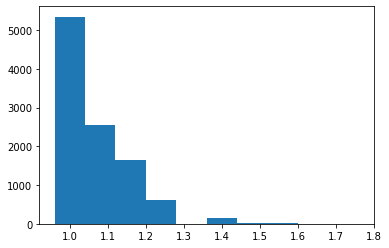

In [108]:
# YOUR CODE HERE
plt.hist(df_part1['surge'], align='left')

Now plot the surge multiplier on the x-axis and the conversion-rate on the y-axis.  We know that the surge price causes conversion to fall, based on `conversion_rate`,
but your plot should show that conversion is actually *increasing* in the surge price for part of the domain of the plot.

Explain why this is. To support your answer, think about:
* the effect that a high desire to ride has on the sessions / drivers ratio (recall the plot you made above)
* the effect of the sessions / drivers ratio on surge (plot it, if it's helpful)
* the effect that a high desire to ride has on conversion

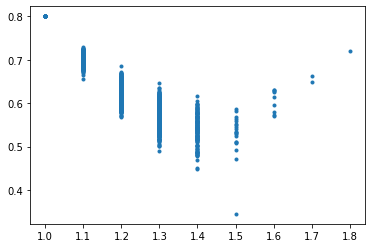

In [109]:
# YOUR CODE AND EXPLANATION HERE
plt.plot(df_part1['surge'],df_part1['conversion'], '.')

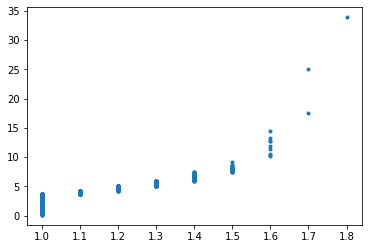

In [112]:
#Surge vs sessions/drivers to aid with explatation above
plt.plot(df_part1['surge'], df_part1['sessions']/df_part1['drivers'],'.')

Conversion is increasing for the portion of the graph surge (1.5, 1.8). A higher desire to ride results in a higher sessions/drivers ratio. As shown in the graph created above, a higher surge also results in a higher sessions/drivers ratio. Finally, a high desire to ride results in conversion decreasing slower as surge increases. When taking in to account the following factors, it makes sense that as surge rate reaches an inflection point around 1.5, the conversion rate actually begins to increase as a combination of a) a higher sessions/drivers ratio, as indicated by the analysis in the above graph and b) a higher desire to ride that results in higher surge prices for this data.

Ultimately, this is an example of causality vs correlation. The higher surge price is not causing the average conversion to increase from surges (1.5,1.8), but rather the hidden confounder of a higher desire to ride (which jusifies the high surge values) can expain the higher conversion at these intervals.

### A/B experiment

One way to deal with the issue that you just saw above is to run an experiment. We will simulate an experiment where  prices are randomly modified in each location_id by a small amount. When considering such experiments, it is important to design them in such a way that market participants are not harmed, by ensuring that the price changes are small and that guardrails are put in place.

With probability 50%, assign each location_id, hour, and date to a treatment group that is either 0 (control) or 1 (treatment). Store this in a field called `df['treatment']`.

Then, create a new surge multiplier, `df['new_surge']`, that is:
* the same as the old surge multiplier for location_id / hour / date assigned to control
* the old surge multiplier minus 0.2 for location_id / hour / date assigned to treatment (i.e., if you are a lucky rider in a treated location / hour / date, you get a 20\% discount)

Note that this experiment offers a discount if the original surge multiplier was 1. Driver payments could be designed to be what they would have been without the rider discount. This reduces the impact on market participants.

In [149]:
# YOUR CODE HERE
df_part1['treatment'] = df_part1['location_id'] #initiate the column so treatment exists
for index,row in df_part1.iterrows():
    x = np.random.randint(0,2)
    df_part1.loc[index,'treatment'] = x #replace treatment with its proper value

In [150]:
df_part1['new_surge'] = df_part1['location_id'] #initiate the column so new_surge exists
for index,row in df_part1.iterrows():
    if row['treatment'] == 0:
        df_part1.loc[index,'new_surge'] = row['surge'] #replace treatment with its proper value
    else:
        df_part1.loc[index,'new_surge'] = row['surge'] - 0.2 #replace treatment with its proper value

Then calculate a new conversion rate, `df['new_conversion']`, for each location_id / hour / date based on the new surge multiplier.

In [152]:
# YOUR CODE HERE
new_conversion_array=[]
for index,row in df_part1.iterrows():
    new_conversion_array.append(conversion_rate(row['new_surge'],row['desire_to_ride']))
df_part1['new_conversion'] = new_conversion_array

Then, using a groupby on surge (before it was modified in the experiment),
and using only the location / hour / dates in treatment,
calculate the average of the conversion rates that results from the new surge multiplier.
Put this a series called `conversion_treatment`.

Then do the same thing for control and put the result in `conversion_control`.

Plot `conversion_treatment` and `conversion_control` versus surge multplier.
Then plot their difference versus the surge multiplier.  

This difference is the "treatment effect" and quantifies the causal impact on conversion of lowering the surge multiplier by 0.1, as a function of the original value of the surge multplier.
You should see that it is positive for all values of the surge multplier. 

In [159]:
# YOUR CODE HERE
conv_treatment = df_part1[df_part1['treatment'] == 1]
conv_control = df_part1[df_part1['treatment'] == 0]
conversion_treatment = conv_treatment.groupby('surge')['new_conversion'].mean()
conversion_control = conv_control.groupby('surge')['new_conversion'].mean()

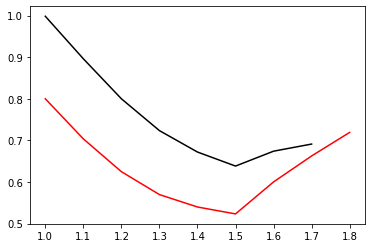

In [165]:
plt.plot(conversion_treatment, color = 'black')
plt.plot(conversion_control, color='red')

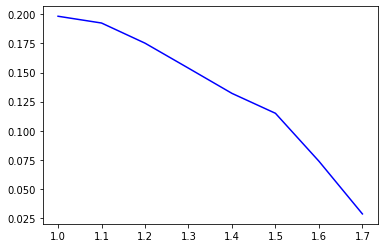

In [166]:
plt.plot(conversion_treatment-conversion_control,color='blue')